In [64]:
import pandas as pd
import numpy as np
from glob import glob
import keras
import os
import AngularGrid
import tensorflow as tf
import wandb

from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, concatenate, Concatenate
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
def readFile(file):
  train = pd.read_csv(file)
  return train

def buildTrainXY(train_x, train_y):
  X_train, Y_train = [], []
  X_train = [[train_x.iloc[0]['pos_x'], train_x.iloc[0]['pos_y'], train_x.iloc[0]['vel_x'], train_x.iloc[0]['vel_y']]]
  y_lst = []
  for i in range(len(train_y)):
    # y_lst.append([train_y.iloc[i]['pos_x'], train_y.iloc[i]['pos_y'], train_y.iloc[i]['vel_x'], train_y.iloc[i]['vel_y']])
    y_lst.append(train_y.iloc[i]['pos_x'])
    y_lst.append(train_y.iloc[i]['pos_y'])
    y_lst.append(train_y.iloc[i]['vel_x'])
    y_lst.append(train_y.iloc[i]['vel_y'])
  Y_train.append([y_lst])
  
  Y_train = list(np.array(Y_train).flat)
  return X_train, Y_train

def buildTrainAG(train_ag):
  AG_train = [train_ag.iloc[0]]
  return AG_train

def get_ADE_FDE(pred, test, pred_time):
  ade, fde = 0, 0

  for i in range(len(pred)):
    individual_ade, individual_fde = 0, 0
    pred_info = pred.iloc[i]
    test_info = test.iloc[i]
    t = 0
  
    for p in range(0, pred.shape[1],4):
      t += 1
      pred_pos = AngularGrid.pt(pred_info[p], pred_info[p+1])
      test_pos = AngularGrid.pt(test_info[p], test_info[p+1])
      dist = AngularGrid.pt.distance(pred_pos, test_pos)
      individual_ade += dist
      if t == pred_time:
        individual_fde += dist
      else:
        pass
    individual_ade = individual_ade / pred_time
    # print('ade = ', individual_ade,'\nfde = ', individual_fde)
    ade += individual_ade
    fde += individual_fde
  ade = ade / len(pred)
  fde = fde / len(pred)
  return np.round(ade, 6), np.round(fde, 6)

def buildTrainMap(train_map):
  train_map = train_map.to_numpy()
  train_map = train_map / 255
  return train_map/255

In [66]:
wandb.init(project="MotionPrediction")

In [67]:
folder = "/home/linsea/motion_ws/src/motion_prediction/data/ETH/"
file_num = 7122
test_rate = 0.2
test_num = int(file_num * test_rate)
i = 1
map_size = 20
X_train ,Y_train , AG_train, Map_train= [], [], [], []
X_test ,Y_test , AG_test, Map_test= [], [], [], []
map_info = []
index = 0
AE_model = keras.models.load_model("/home/linsea/motion_ws/src/motion_prediction/script/AE.h5")

for file in glob(os.path.join(folder+'train_x/',"*.csv")):
  index +=1
  if index % 100 == 0:
    print(index)
  file_name = file.split('/')[-1]
  try:
    train_x = readFile(file)
    train_y = readFile(folder + 'train_y/' + file_name)
    train_ag = readFile(folder + 'train_ag/' + file_name)
    train_map = pd.read_csv(folder + 'map_info/' + file_name, header=None)
  except:
    print(file_name, 'read error')
    continue

  X, Y = buildTrainXY(train_x, train_y)
  AG = buildTrainAG(train_ag)
  MP = buildTrainMap(train_map)
  MP = MP.reshape(1, map_size, map_size, 1)
  # MP = AE_model(MP)
  if i > test_num:
    X_train.append(X)           #ped_state
    Y_train.append(Y)           #ped_pred
    AG_train.append(AG)         #ag
    Map_train.append(train_map) #map
  else:
    X_test.append(X)
    Y_test.append(Y)
    AG_test.append(AG)
    Map_test.append(train_map)
  i+=1

X_train = np.array(X_train)
Y_train = np.array(Y_train)
AG_train = np.array(AG_train)
Map_train = np.array(Map_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
AG_test = np.array(AG_test)
Map_test = np.array(Map_test)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100


In [68]:
print('ped state shape:\t',X_train.shape)
print('ag shape:\t\t',AG_train.shape)
print('ped pred shape:\t\t',Y_train.shape)
print('map_info:\t\t', Map_train.shape)

print('\nped state test shape:\t',X_test.shape)
print('ag test shape:\t\t',AG_test.shape)
print('ped pred test shape:\t',Y_test.shape)
print('map test info:\t\t', Map_test.shape)

ped state shape:	 (5698, 1, 4)
ag shape:		 (5698, 1, 72)
ped pred shape:		 (5698, 20)
map_info:		 (5698, 20, 20)

ped state test shape:	 (1424, 1, 4)
ag test shape:		 (1424, 1, 72)
ped pred test shape:	 (1424, 20)
map test info:		 (1424, 20, 20)


settings

In [69]:
epochs = 500
lr = 0.001
batch_size = 16
callBack = EarlyStopping(monitor='val_loss', patience = 10)

In [70]:
wb_call = WandbCallback(monitor='val_loss',save_graph=True)
cfg = wandb.config
cfg.architecture = 'ped state + map'
# cfg.architecture = 'ped state + map + surrounding'
cfg.dataset = 'ETH'
cfg.epochs = epochs
cfg.learning_rate = lr
cfg.batch_size = batch_size
cfg.ped_input_shape = X_train.shape
cfg.AG_input_shape = AG_train.shape
cfg.output_shape = Y_train.shape

In [71]:
ped_input = keras.Input(shape=( 1, 4), name= 'ped')
ped_features = LSTM(32)(ped_input)

# ag_input = keras.Input(shape=( 1, 72), name= 'ag')
# ag_features = Dense(128)(ag_input)
# ag_features = LSTM(128)(ag_features)

# map_input = keras.Input(shape=( map_size, map_size), name= 'map')
# map_features = Dense(64)(map_input)
# map_features = LSTM(256)(map_features)

# x = concatenate([ ped_features, ag_features, map_features], axis=-1)
x = concatenate([ ped_features], axis=-1)
x = tf.expand_dims(x,axis=1)
x = LSTM(160)(x)

x = Dense(256, activation="relu")(x)
x = Dense(128, activation="linear")(x)

ped_pred = Dense(20, name='ped_pred')(x)

# model = keras.Model(inputs = [ped_input, ag_input, map_input],
model = keras.Model(inputs = [ped_input],
                    outputs = [ped_pred],
)
model.compile(
    optimizer = Adam(lr),
    loss=keras.losses.MeanSquaredError(),
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ped (InputLayer)            [(None, 1, 4)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                4736      
                                                                 
 concatenate_2 (Concatenate)  (None, 32)               0         
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1, 32)            0         
 a)                                                              
                                                                 
 lstm_7 (LSTM)               (None, 160)               123520    
                                                                 
 dense_6 (Dense)             (None, 256)               41216     
                                                           

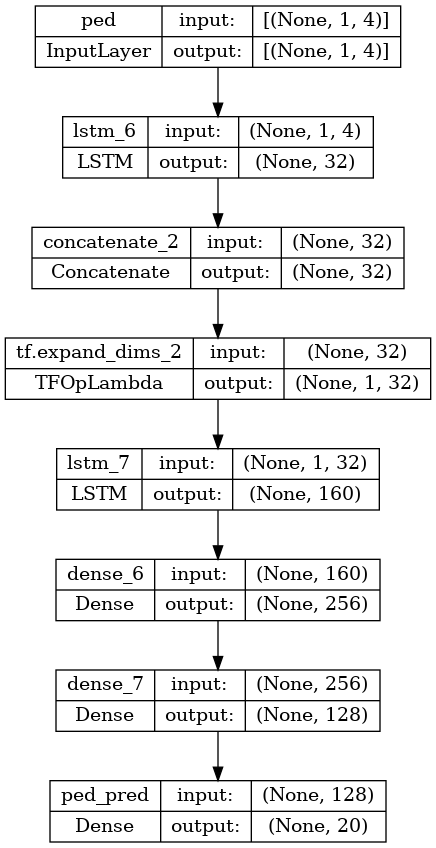

In [72]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [73]:
ped_data = X_train
ag_data = AG_train
map_data = Map_train
ped_pred_data = Y_train

model.fit(
  # {'ped': ped_data,'ag': ag_data, 'map': map_data},
  {'ped': ped_data},
  {'ped_pred': ped_pred_data},
  epochs = epochs,
  batch_size = batch_size,
  validation_split=0.2,
  callbacks = [callBack]
)


Epoch 1/500
285/285 [==============================] - 3s 5ms/step - loss: 2.1353 - val_loss: 0.0895
Epoch 2/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0681 - val_loss: 0.0670
Epoch 3/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0566 - val_loss: 0.0534
Epoch 4/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0548 - val_loss: 0.0515
Epoch 5/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0522 - val_loss: 0.0532
Epoch 6/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0479 - val_loss: 0.0446
Epoch 7/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0477 - val_loss: 0.0517
Epoch 8/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0477 - val_loss: 0.0522
Epoch 9/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0436 - val_loss: 0.0525
Epoch 10/500
285/285 [==============================] - 1s 3ms/step - loss: 0.0470 - val_lo

In [75]:
# preds = model.predict([X_test, AG_test, Map_test])
# loss_metrics = model.evaluate([X_test, AG_test, Map_test], Y_test)
preds = model.predict([X_test])
loss_metrics = model.evaluate([X_test], Y_test)

45/45 [==============================] - 0s 1ms/step - loss: 0.0463


In [76]:
preds = pd.DataFrame(preds)
Y_test = pd.DataFrame(Y_test)

In [77]:
ade, fde = get_ADE_FDE(preds, Y_test, 5)
print('ade = ', ade,'\nfde = ', fde)

wandb.config.ade = ade
wandb.config.fde = fde
image = wandb.Image("/home/linsea/motion_ws/src/motion_prediction/script/multi_input_and_output_model.png", caption="Input image")

      


ade =  0.220059 
fde =  0.361747


In [78]:
wandb.finish()

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [31]:
def world2image(traj_w, H_inv):    
    # Converts points from Euclidean to homogeneous space, by (x, y) → (x, y, 1)
    traj_homog = np.hstack((traj_w, np.ones((traj_w.shape[0], 1)))).T  
    # to camera frame
    traj_cam = np.matmul(H_inv, traj_homog)  
    # to pixel coords
    traj_uvz = np.transpose(traj_cam/traj_cam[2]) 
    return traj_uvz[:, :2].astype(int)    

In [35]:
OPENTRAJ_ROOT = '/home/linsea/motion_ws/src/motion_prediction/data/ETH/'

In [45]:
preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9.898164,5.882195,0.518452,-0.267520,10.098023,5.713127,0.449623,-0.278381,10.245667,5.644663,0.395318,-0.228061,10.459359,5.599946,0.388481,-0.154398,10.617659,5.481295,0.377042,-0.285492
1,2.878191,6.373462,-1.584761,0.127155,2.252623,6.383071,-1.565132,0.040382,1.600829,6.407443,-1.572877,0.006296,0.998777,6.398890,-1.479954,-0.044661,0.428872,6.346901,-1.522448,-0.070722
2,0.780239,4.238316,1.593198,0.059741,1.435820,4.251183,1.579597,0.064476,2.053277,4.287826,1.584782,0.062532,2.696025,4.320569,1.616715,0.109640,3.352220,4.355174,1.592011,0.082523
3,10.403296,4.565614,1.263508,-0.017297,10.884107,4.504884,1.204195,-0.029418,11.343209,4.547332,1.123148,0.050675,11.803520,4.602933,1.074870,0.141770,12.228596,4.607491,1.071395,0.023353
4,5.819511,2.822864,-1.150857,-0.329040,5.342546,2.652011,-1.163412,-0.312715,4.872060,2.556997,-1.163401,-0.285149,4.409340,2.452156,-1.163985,-0.268464,3.971050,2.319236,-1.145126,-0.326050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,7.514318,7.507670,1.488279,0.102199,8.059171,7.453294,1.445585,-0.070919,8.628420,7.466110,1.372410,-0.069532,9.208674,7.463243,1.379562,-0.069527,9.757259,7.378599,1.358967,-0.187673
1420,-2.158342,0.410482,1.325283,1.041505,-1.595332,0.797576,1.385947,0.907533,-1.045235,1.139186,1.440032,0.792766,-0.461269,1.448922,1.463550,0.714534,0.139792,1.705157,1.450884,0.651033
1421,6.475162,5.190851,-1.163767,-0.350955,5.988856,5.017724,-1.198583,-0.358906,5.501228,4.900568,-1.218257,-0.338642,5.037741,4.778307,-1.198436,-0.327856,4.565668,4.615435,-1.211284,-0.376742
1422,1.064112,4.997794,1.690207,0.112893,1.753179,5.019712,1.668741,0.074785,2.404187,5.061930,1.663151,0.062090,3.079029,5.095041,1.701839,0.097192,3.771681,5.117633,1.674162,0.055038


In [46]:
Y_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9.798168,5.904934,0.542248,-0.227498,10.036299,5.853132,0.591297,-0.178751,10.271205,5.761933,0.579232,-0.375975,10.499685,5.552352,0.522813,-0.471005,10.689456,5.385129,0.623330,-0.324464
1,2.712082,6.434371,-1.752424,0.146799,1.982263,6.516780,-1.711682,0.256907,1.342736,6.639896,-1.747750,0.204909,0.584064,6.680708,-1.840499,0.212790,-0.129663,6.810128,-1.809471,0.212145
2,0.752782,4.269033,1.477154,0.022034,1.311896,4.255613,1.446204,-0.090944,1.909746,4.196277,1.617992,0.016888,2.606290,4.269123,1.650561,-0.038684,3.230195,4.165330,1.499653,-0.091721
3,10.337311,4.520781,1.337804,-0.091681,10.849445,4.505016,1.371234,0.056442,11.434299,4.565935,1.351537,0.056349,11.930674,4.550095,1.283930,0.104744,12.461443,4.649730,2.101657,0.600668
4,5.932821,2.729624,-0.871435,-0.478760,5.608708,2.601543,-1.250733,0.061101,4.932234,2.778504,-1.265480,0.004480,4.596323,2.605127,-0.681857,-0.655990,4.386749,2.253712,-0.859554,-0.550758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,7.302245,7.514855,1.924292,-0.029845,8.187527,7.412357,2.102108,0.103751,8.983931,7.597856,1.555656,0.240953,9.432051,7.605120,1.260148,-0.042196,9.992050,7.564099,1.438008,-0.105336
1420,-2.230651,0.468097,0.941905,1.228466,-1.907433,1.003826,1.269348,1.218152,-1.215173,1.442619,1.571613,0.968288,-0.650142,1.778457,1.401756,0.833163,-0.093768,2.109150,1.500697,0.704736
1421,6.434446,5.231964,-1.172601,-0.217043,5.943892,5.208508,-1.124822,-0.116501,5.534589,5.138763,-1.089558,-0.226900,5.072246,5.026988,-1.058043,-0.446943,4.688155,4.781208,-1.010101,-0.399074
1422,1.013141,4.989112,1.658283,0.058482,1.670899,5.012309,1.626814,0.001960,2.314592,4.990680,1.660581,-0.000588,2.999363,5.011839,1.637697,0.054497,3.624750,5.034277,1.550903,0.055646


In [53]:
pred_info = preds.iloc[index]
ppp = pred_info[0]
# pred_info = [[pred_info[i], pred_info[index][i+1]]]
print(ppp)

9.898164


pred_info [[7.135112, 5.9308357]]
y_info: [[7.133132, 5.9963228]]
pred_info [[6.5745854, 5.647824]]
y_info: [[6.5582615, 5.8570969]]
pred_info [[5.9990473, 5.4481454]]
y_info: [[5.9242438, 5.633132]]
pred_info [[5.4445686, 5.234866]]
y_info: [[5.3342879, 5.5735729]]
pred_info [[4.8730507, 4.9957275]]
y_info: [[4.7753322, 5.4252955]]


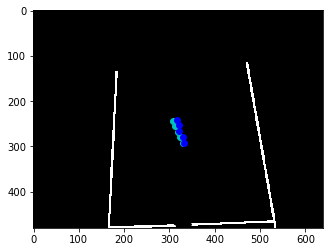

In [63]:
from symbol import yield_stmt


img = mpimg.imread(OPENTRAJ_ROOT+'map.png')
implot = plt.imshow(img, cmap='gray')
c = ['c', 'b', 'g', 'r', 'm', 'y', 'k', 'w']
index = 56

for i in range(0,19,4):
  pred_info = preds.iloc[index]
  y_info = Y_test.iloc[index]
  p = [[pred_info[i], pred_info[i+1]]]
  print('pred_info',p)
  y = [[y_info[i], y_info[i+1]]]
  print('y_info:',y)
  H = (np.loadtxt(os.path.join(OPENTRAJ_ROOT, "H.txt")))
  H_inv = np.linalg.inv(H)
  convert_pred = world2image(np.array(p), H_inv)
  convert_y = world2image(np.array(y), H_inv)

  color = int(index%8)

  img = plt.scatter(convert_pred[0][1], convert_pred[0][0], c=c[color])
  img = plt.scatter(convert_y[0][1], convert_y[0][0], c=c[color+1])

In [ ]:
def get_graph(pred, test, pred_time):

  for i in range(len(pred)):
    pred_info = pred.iloc[i]
    test_info = test.iloc[i]
    t = 0
  
    for p in range(0, pred.shape[1],4):
      t += 1
      pred_pos = AngularGrid.pt(pred_info[p], pred_info[p+1])
      test_pos = AngularGrid.pt(test_info[p], test_info[p+1])
      
      dist = AngularGrid.pt.distance(pred_pos, test_pos)
      individual_ade += dist
      if t == pred_time:
        individual_fde += dist
      else:
        pass
    individual_ade = individual_ade / pred_time
    # print('ade = ', individual_ade,'\nfde = ', individual_fde)
    ade += individual_ade
    fde += individual_fde
  ade = ade / len(pred)
  fde = fde / len(pred)
  return np.round(ade, 6), np.round(fde, 6)

In [ ]:
def get_map_feature(center_pt, map, cut_size=30):
  x = center_pt[1]
  y = center_pt[0]
  helf_size = int(cut_size/2)
  map_feature = []
  for i in range(x - helf_size, x + helf_size):
    for j in range(y - helf_size, y + helf_size):
      map_feature.append(map[i][j])
  map_feature = np.array(map_feature).reshape(cut_size, cut_size)
  return np.array(map_feature)